In [1]:
import pandas as pd
import io
import os
import gzip
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import swifter
import warnings
import time
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
def get_vcf_names(vcf_path):
    with open(vcf_path, "rt") as ifile:
        for line in ifile:
            if line.startswith("#CHROM"):
                vcf_names = [x for x in line.split('\t')]
                break
    ifile.close()
    return vcf_names

In [3]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [4]:
expressions = pd.read_csv(parent_dir + '/data/raw/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz', sep='\t')
expressions_22 = expressions[expressions['Chr'].astype(str) == '22']

In [5]:
expressions_22.head()

,TargetID,Gene_Symbol,Chr,Coord,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,...,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
22,ENSG00000249263.2,ENSG00000249263.2,22,17140518,0.340656,0.318942,-0.009145,0.231503,0.089713,0.482984,...,0.032117,0.213629,0.225474,0.134216,0.128749,0.060841,0.298061,-0.011292,0.058276,-0.013384
29,ENSG00000224688.1,ENSG00000224688.1,22,21496660,4.194827,3.369440,2.335470,4.477910,3.641758,3.296741,...,4.669164,3.918440,4.977372,3.253683,3.322997,6.613617,3.438039,3.768840,3.248447,4.300825
45,ENSG00000075240.12,ENSG00000075240.12,22,46971909,3.531803,3.635541,1.251434,3.007745,3.574070,4.569758,...,4.057426,3.736969,3.156168,6.785470,5.646243,2.418243,4.678466,4.626435,5.101994,4.100622
81,ENSG00000099937.6,ENSG00000099937.6,22,21128167,0.519054,0.399216,0.078965,0.145628,0.446993,0.217271,...,0.621082,0.414906,1.047612,0.353794,0.253339,0.492650,0.449070,0.081118,0.164197,0.287428
85,ENSG00000099998.12,ENSG00000099998.12,22,24641110,0.073630,0.041109,0.017493,-0.020552,0.000059,-0.007782,...,0.045730,0.003584,0.027056,0.007583,0.063843,0.059052,-0.008820,0.017421,0.010471,0.105646


In [7]:
pops = pd.read_csv(os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), 'data/raw')) + '/ALL_1000G_phase1integrated_v3.sample', sep=' ')

In [8]:
pops.head()

,sample,population,group,sex
0,HG00096,GBR,EUR,1
1,HG00097,GBR,EUR,2
2,HG00099,GBR,EUR,2
3,HG00100,GBR,EUR,2
4,HG00101,GBR,EUR,1


## Whole Chr22

In [9]:
def get_cis_snps(x, cis_thresh, snps):
    return snps['POS'][(abs(snps['POS'] - x['Coord']) < cis_thresh)].index

In [10]:
def regress(x, snps, total_count, samples):
    exp = x.iloc[4:-1]
    
    valid_keys_exp = exp.index.intersection(samples)
    exp = exp.loc[valid_keys_exp]
    
    sig_alleles = []
    
    for snp in x['local']:

        allele = snps.loc[snp]
        
        valid_keys_allele = allele.index.intersection(samples)
        allele = allele.loc[valid_keys_allele]

        merged = pd.merge(exp, allele, left_index=True, right_index=True)
        merged.columns = ['expression', 'allele']

        slope, intercept, r_value, p_value, std_err = linregress(merged['allele'].values.astype(float), merged['expression'].values.astype(float))
        
        if p_value <= 0.05 / total_count:
            sig_alleles.append(np.array([snp, slope, std_err, p_value]))
            
        
    return sig_alleles
    

In [93]:
names = get_vcf_names(parent_dir + '/data/temp/chr22.vcf')
vcf = pd.read_csv(parent_dir + '/data/temp/chr22.vcf', chunksize=150_000, comment='#',low_memory=False, delim_whitespace=True, header=None, names=names)

significants = 0
p_values = []
total_count = 0


for i, chunk in enumerate(vcf):

    
    expressions_22.loc[:, 'local'] = expressions_22.swifter.apply(get_cis_snps, cis_thresh=500_000, snps=chunk, axis=1)
    
    total_count += expressions_22['local'].apply(len).sum()

Pandas Apply:   0%|          | 0/633 [00:00<?, ?it/s]

In [94]:
cnt = expressions_22['local'].apply(len)

In [95]:
cnt

22       2255
29       1792
45       3411
81       2381
85       2328
         ... 
23631    4185
23656    3456
23664    2393
23690    2204
23693    2203
Name: local, Length: 633, dtype: int64

Text(0.5, 1.0, 'Histogram of Number of cis-SNPs per Gene')

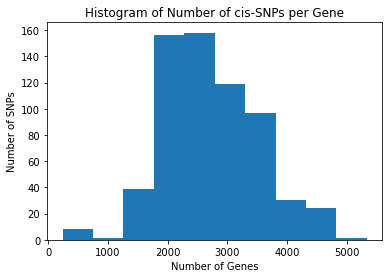

In [96]:
plt.hist(cnt)
plt.ylabel('Number of SNPs')
plt.xlabel('Number of Genes')
plt.title('Histogram of Number of cis-SNPs per Gene')

In [ ]:
total_count

In [ ]:
start = time.time()

target_pops = ['CEU', 'FIN', 'GBR', 'TSI', 'YRI']
samples = pops['sample'][pops['population'].isin(target_pops)]

names = get_vcf_names(parent_dir + '/data/temp/chr22.vcf')
vcf = pd.read_csv(parent_dir + '/data/temp/chr22.vcf', chunksize=50_000, comment='#',low_memory=False, delim_whitespace=True, header=None, names=names)

significants = pd.DataFrame(columns=['gene', 'snp', 'pos', 'slope', 'SE', 'pvalue'])

for i, chunk in enumerate(vcf):
    print(i)
    
    expressions_22.loc[:, 'local'] = expressions_22.swifter.apply(get_cis_snps, cis_thresh=500_000, snps=chunk, axis=1)
    alleles = chunk.iloc[:, 9:].applymap(lambda x: sum(int(i) for i in str(x).split('/')))
    alleles.columns = alleles.columns.str.split('_').str[0].str.strip()

    expressions_22.loc[:, 'info'] = expressions_22.apply(regress, snps=alleles, total_count=total_count, samples=samples, axis=1)
    
    for idx, row in expressions_22.iterrows():
    
        for sig in row['info']:
            record = pd.DataFrame.from_dict({
                'gene': [row['TargetID']],
                'snp': [chunk.loc[int(sig[0])]['ID']],
                'pos': [chunk.loc[int(sig[0])]['POS']],
                'slope': [sig[1]],
                'SE': [sig[2]],
                'pvalue': [sig[3]]
            })
            
            significants = pd.concat([significants, record], ignore_index=True)
    
end = time.time()

In [ ]:
print(end - start)

In [ ]:
significants.to_csv('locuszoom/chr22_all_test.csv', index=False)

## Plots and Analysis

In [11]:
significants = pd.read_csv(parent_dir + '/data/out/ch22_all.csv')

In [12]:
significants[significants['gene'] == 'ENSG00000100376.7'][['snp',]].to_csv('snps.csv', index=False)

In [13]:
significants.shape[0]

6431

In [14]:
allkeys = significants.groupby(['gene', 'snp']).groups.keys()

In [15]:
ceu = pd.read_csv(parent_dir + '/data/out/chr22_CEU.csv')
fin = pd.read_csv(parent_dir + '/data/out/chr22_FIN.csv')
gbr = pd.read_csv(parent_dir + '/data/out/chr22_GBR.csv')
tsi = pd.read_csv(parent_dir + '/data/out/chr22_TSI.csv')
yri = pd.read_csv(parent_dir + '/data/out/chr22_YRI.csv')

In [16]:
ceukeys = ceu.groupby(['gene', 'snp']).groups.keys()
finkeys = fin.groupby(['gene', 'snp']).groups.keys()
gbrkeys = gbr.groupby(['gene', 'snp']).groups.keys()
tsikeys = tsi.groupby(['gene', 'snp']).groups.keys()
yrikeys = yri.groupby(['gene', 'snp']).groups.keys()

### Venn Diagram of Overlap

In [19]:
from venn import venn

In [20]:
from matplotlib.colors import ListedColormap

In [21]:
import matplotlib

In [22]:
new_colors = ['#1f77b4', '#ff7f0e','#ff7f0e', '#d62728',
              '#9467bd', '#2ca02c', '#e377c2', '#d62728',
              '#bcbd22', '#9467bd']
cmp = ListedColormap(new_colors)

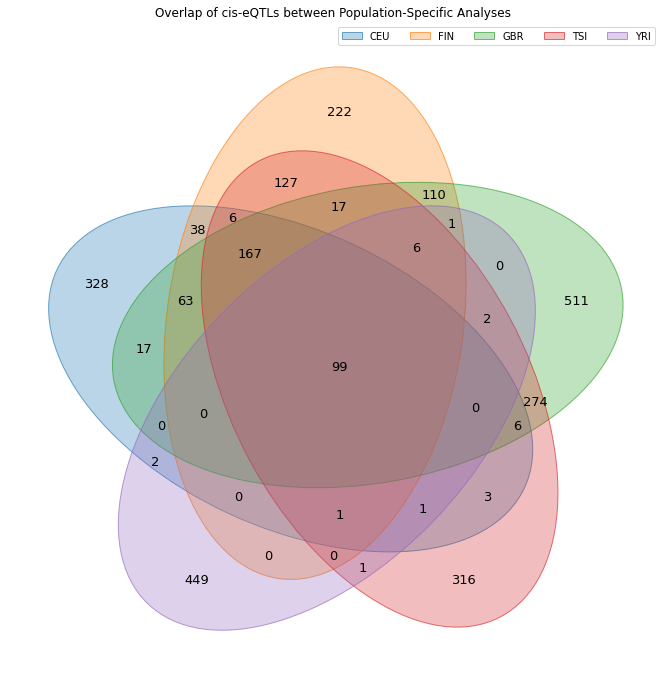

In [90]:
labels = ['CEU', 'FIN', 'GBR', 'TSI', 'YRI']
sets = {
    labels[0]: set(ceukeys),
    labels[1]: set(finkeys),
    labels[2]: set(gbrkeys),
    labels[3]: set(tsikeys),
    labels[4]: set(yrikeys)
}
fig, ax = plt.subplots(1, figsize=(16,12))
venn(sets, ax=ax, cmap=cmp, alpha=0.3)
plt.title('Overlap of cis-eQTLs between Population-Specific Analyses')
plt.legend(labels, ncol=6)
plt.savefig('plots/venn', bbox_inches='tight')

### Box and Whikser Plot

In [97]:
sig = significants

In [98]:
sig.sort_values(by='pvalue')

,gene,snp,pos,slope,SE,pvalue
1609,ENSG00000184674.7,esv2669470,24343050,-8.163390,0.225680,5.865226e-131
4543,ENSG00000100376.7,rs7285172,45726345,13.414176,0.460170,7.473595e-103
4532,ENSG00000100376.7,rs2142552,45719497,13.414176,0.460170,7.473595e-103
4614,ENSG00000100376.7,rs136592,45783722,13.241436,0.455206,1.353426e-102
4528,ENSG00000100376.7,rs104664,45711854,13.292276,0.464239,1.119015e-100
...,...,...,...,...,...,...
6298,ENSG00000100425.13,rs4824108,50271428,-0.655047,0.115779,2.846208e-08
6300,ENSG00000100425.13,rs4824110,50271631,-0.655047,0.115779,2.846208e-08
6281,ENSG00000100425.13,rs4823960,50146609,-1.038481,0.183573,2.856733e-08
6297,ENSG00000100425.13,rs5769763,50269255,-0.649379,0.114804,2.866933e-08


In [103]:
names = get_vcf_names(parent_dir + '/data/temp/chr22.vcf')
vcf = pd.read_csv(parent_dir + '/data/temp/chr22.vcf', chunksize=50_000, comment='#',low_memory=False, delim_whitespace=True, header=None, names=names)
ch = vcf.get_chunk()

In [104]:
ch = vcf.get_chunk()

In [105]:
ex = expressions_22[expressions_22['Gene_Symbol'] == 'ENSG00000100376.7'].T.iloc[4:-2]

In [106]:
al = ch[ch['ID'] == 'rs7285172'].iloc[:, 9:].applymap(lambda x: sum(int(i) for i in str(x).split('/')))
al.columns = al.columns.str.split('_').str[0].str.strip()
al = al.T

In [109]:
merged = pd.merge(ex, al, left_index=True, right_index=True)
merged.columns = ['expression', 'genotype']

In [112]:
import matplotlib.pyplot as plt

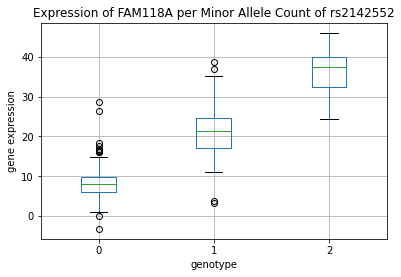

In [139]:
merged.boxplot(column=['expression'], by='genotype')
plt.suptitle('')
plt.title('Expression of FAM118A per Minor Allele Count of rs2142552')
plt.ylabel('gene expression')
plt.savefig('plots/boxwhisker', bbox_inches='tight')

### Bar plot

In [114]:
barplot = pd.DataFrame(columns = ['POP', 'CNT'])

barplot = pd.concat([barplot, pd.DataFrame({'POP': ['CEU'], 'CNT': [ceu.shape[0]]})], ignore_index=True)
barplot = pd.concat([barplot, pd.DataFrame({'POP': ['FIN'], 'CNT': [fin.shape[0]]})], ignore_index=True)
barplot = pd.concat([barplot, pd.DataFrame({'POP': ['GBR'], 'CNT': [gbr.shape[0]]})], ignore_index=True)
barplot = pd.concat([barplot, pd.DataFrame({'POP': ['TSI'], 'CNT': [tsi.shape[0]]})], ignore_index=True)
barplot = pd.concat([barplot, pd.DataFrame({'POP': ['YRI'], 'CNT': [yri.shape[0]]})], ignore_index=True)

In [115]:
barplot

,POP,CNT
0,CEU,731
1,FIN,857
2,GBR,1273
3,TSI,1026
4,YRI,562


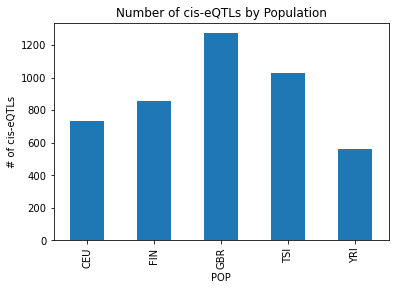

In [116]:
barplot.plot(kind='bar', x='POP', y='CNT', legend=False, ylabel='# of cis-eQTLs')
plt.title('Number of cis-eQTLs by Population')
plt.savefig('plots/barplot', bbox_inches='tight')

### Stacked bar plot

In [117]:
ceu_cnt = dict()
ceu_cnt['30+'] = 0

for i in range(1, 169):
    if i < 30:
        if i in ceu.groupby('gene')['snp'].count().value_counts().index:
            ceu_cnt[i] = ceu.groupby('gene')['snp'].count().value_counts().loc[i]
        else:
            ceu_cnt[i] = 0
            
    else :
        if i in ceu.groupby('gene')['snp'].count().value_counts().index:
            ceu_cnt['30+'] += ceu.groupby('gene')['snp'].count().value_counts().loc[i]

In [118]:
fin_cnt = dict()
fin_cnt['30+'] = 0

for i in range(1, 169):
    if i < 30:
        if i in fin.groupby('gene')['snp'].count().value_counts().index:
            fin_cnt[i] = fin.groupby('gene')['snp'].count().value_counts().loc[i]
        else:
            fin_cnt[i] = 0
            
    else :
        if i in fin.groupby('gene')['snp'].count().value_counts().index:
            fin_cnt['30+'] += fin.groupby('gene')['snp'].count().value_counts().loc[i]

In [119]:
gbr_cnt = dict()
gbr_cnt['30+'] = 0

for i in range(1, 169):
    if i < 30:
        if i in gbr.groupby('gene')['snp'].count().value_counts().index:
            gbr_cnt[i] = gbr.groupby('gene')['snp'].count().value_counts().loc[i]
        else:
            gbr_cnt[i] = 0
            
    else :
        if i in gbr.groupby('gene')['snp'].count().value_counts().index:
            gbr_cnt['30+'] += gbr.groupby('gene')['snp'].count().value_counts().loc[i]

In [120]:
tsi_cnt = dict()
tsi_cnt['30+'] = 0

for i in range(1, 169):
    if i < 30:
        if i in tsi.groupby('gene')['snp'].count().value_counts().index:
            tsi_cnt[i] = tsi.groupby('gene')['snp'].count().value_counts().loc[i]
        else:
            tsi_cnt[i] = 0
            
    else :
        if i in tsi.groupby('gene')['snp'].count().value_counts().index:
            tsi_cnt['30+'] += tsi.groupby('gene')['snp'].count().value_counts().loc[i]

In [121]:
yri_cnt = dict()
yri_cnt['30+'] = 0

for i in range(1, 169):
    if i < 30:
        if i in yri.groupby('gene')['snp'].count().value_counts().index:
            yri_cnt[i] = yri.groupby('gene')['snp'].count().value_counts().loc[i]
        else:
            yri_cnt[i] = 0
            
    else :
        if i in yri.groupby('gene')['snp'].count().value_counts().index:
            yri_cnt['30+'] += yri.groupby('gene')['snp'].count().value_counts().loc[i]

In [122]:
df = pd.DataFrame()
df['ceu'] = pd.Series(ceu_cnt)
df['fin'] = pd.Series(fin_cnt)
df['gbr'] = pd.Series(gbr_cnt)
df['tsi'] = pd.Series(tsi_cnt)
df['yri'] = pd.Series(yri_cnt)
df = df.reset_index()

target_row = df.iloc[[0],:]
df = df.shift(-1)
df.iloc[-1] = target_row.squeeze()

,index,ceu,fin,gbr,tsi,yri
0,1,21.0,20.0,16.0,21.0,20.0
1,2,2.0,7.0,2.0,6.0,7.0
2,3,6.0,3.0,2.0,2.0,4.0
3,4,4.0,0.0,0.0,1.0,6.0
4,5,2.0,1.0,1.0,2.0,6.0
5,6,3.0,1.0,1.0,0.0,5.0
6,7,0.0,1.0,2.0,1.0,0.0
7,8,1.0,3.0,0.0,1.0,0.0
8,9,1.0,1.0,1.0,3.0,1.0
9,10,0.0,0.0,0.0,0.0,0.0


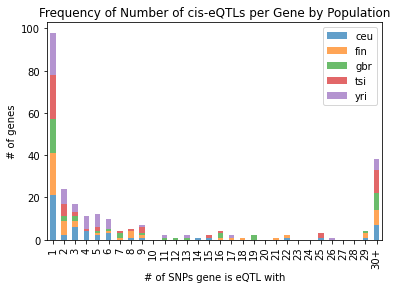

In [123]:
df.plot(kind='bar', stacked=True, x='index', xlabel='# of SNPs gene is eQTL with', ylabel='# of genes', alpha=0.7)
plt.title('Frequency of Number of cis-eQTLs per Gene by Population')
plt.savefig('plots/stackedbplot', bbox_inches='tight')

In [124]:
all_cnt = dict()
all_cnt['30+'] = 0

for i in range(1, 169):
    if i < 30:
        if i in sig.groupby('gene')['snp'].count().value_counts().index:
            all_cnt[i] = sig.groupby('gene')['snp'].count().value_counts().loc[i]
        else:
            all_cnt[i] = 0
            
    else :
        if i in sig.groupby('gene')['snp'].count().value_counts().index:
            all_cnt['30+'] += sig.groupby('gene')['snp'].count().value_counts().loc[i]

In [125]:
df = pd.DataFrame()
df['cnt'] = pd.Series(all_cnt)
df = df.reset_index()
target_row = df.iloc[[0],:]
df = df.shift(-1)
df.iloc[-1] = target_row.squeeze()

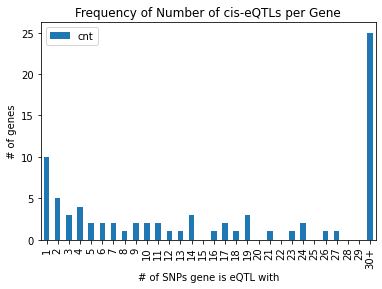

In [126]:
df.plot(kind='bar', stacked=True, x='index', xlabel='# of SNPs gene is eQTL with', ylabel='# of genes')
plt.title('Frequency of Number of cis-eQTLs per Gene')
plt.savefig('plots/stackedbplot2', bbox_inches='tight')

### x-y plot

In [127]:
xyplt = pd.merge(yri.set_index(['gene', 'snp']), ceu.set_index(['gene', 'snp']), left_index=True, right_index=True)

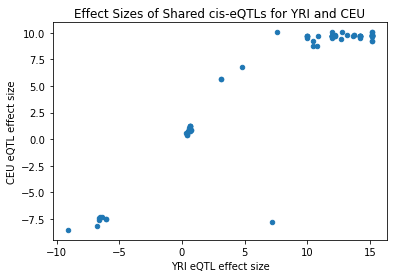

In [128]:
xyplt.plot(kind='scatter', x='slope_x', y='slope_y', xlabel='YRI eQTL effect size', ylabel='CEU eQTL effect size')
plt.title('Effect Sizes of Shared cis-eQTLs for YRI and CEU')
plt.savefig('plots/scatter_ceu_yri', bbox_inches='tight')

In [129]:
xyplt = pd.merge(gbr.set_index(['gene', 'snp']), tsi.set_index(['gene', 'snp']), left_index=True, right_index=True)

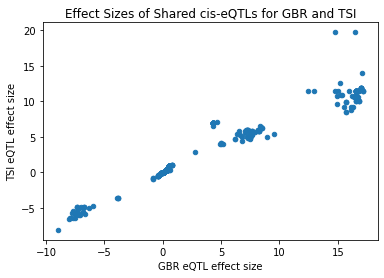

In [130]:
xyplt.plot(kind='scatter', x='slope_x', y='slope_y', xlabel='GBR eQTL effect size', ylabel='TSI eQTL effect size')
plt.title('Effect Sizes of Shared cis-eQTLs for GBR and TSI')
plt.savefig('plots/scatter_gbr_tsi', bbox_inches='tight')

### dot plot

In [131]:
dotplt = pd.merge(ceu.set_index(['gene', 'snp']), fin.set_index(['gene', 'snp']), left_index=True, right_index=True, suffixes = ['_ceu', '_fin'])
dotplt = pd.merge(dotplt, gbr.set_index(['gene', 'snp']), left_index=True, right_index=True)
dotplt = pd.merge(dotplt, tsi.set_index(['gene', 'snp']), left_index=True, right_index=True, suffixes=['_gbr', '_tsi'])
dotplt = pd.merge(dotplt, yri.set_index(['gene', 'snp']), left_index=True, right_index=True)


In [133]:
test = dotplt[dotplt['pvalue_gbr'] == dotplt['pvalue_gbr'].min()][['slope_ceu', 'SE_ceu', 'slope_gbr', 'SE_gbr', 'slope_fin', 'SE_fin', 'slope_tsi', 'SE_tsi', 'slope', 'SE']].iloc[0]

In [135]:
y = [test['slope_ceu'], test['slope_fin'], test['slope_gbr'], test['slope_tsi'], test['slope']]
y_err = [test['SE_ceu'], test['SE_fin'], test['SE_gbr'], test['SE_tsi'], test['SE']]
y

[10.056694212412822,
 13.499042180544214,
 17.124202009109,
 11.424162783114324,
 12.76832691227044]

In [137]:
x = ['CEU', 'FIN', 'GBR', 'TSI', 'YRI']

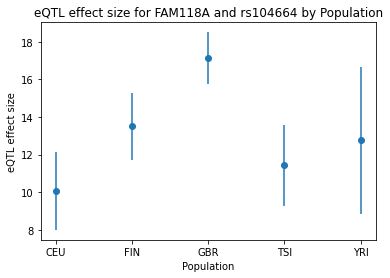

In [138]:
plt.errorbar(x, y, yerr = [2 * e for e in y_err], ls='none', fmt='o')
plt.ylabel('eQTL effect size')
plt.xlabel('Population')
plt.title('eQTL effect size for FAM118A and rs104664 by Population')
plt.savefig('plots/dotplot', bbox_inches='tight')

### Locus Zoom Inputs

In [44]:
yri

,gene,snp,pos,slope,SE,pvalue,Counts
0,ENSG00000253239.1,rs76032591,22046732,398.021903,38.726053,5.758036e-16,3
1,ENSG00000253239.1,rs9610168,22077719,398.021903,38.726053,5.758036e-16,3
2,ENSG00000253239.1,rs4821846,22558460,327.112378,20.084231,2.437779e-26,3
3,ENSG00000128322.6,rs5760118,24266801,2.750781,0.440233,2.291733e-08,3
4,ENSG00000128322.6,rs138659939,24330520,2.750781,0.440233,2.291733e-08,3
...,...,...,...,...,...,...,...
557,ENSG00000172250.10,rs5751302,42939639,1.514917,0.214939,7.543228e-10,11
558,ENSG00000172250.10,rs5758798,42939708,1.331211,0.207119,1.076932e-08,11
559,ENSG00000249222.1,rs34665484,43475261,2.814654,0.412755,2.022362e-09,1
560,ENSG00000100211.6,rs6001299,39294066,9.798328,1.434835,1.939805e-09,1


In [53]:
yri['Counts'] = tsi.groupby(['gene'])['snp'].transform('count')

In [72]:
[e for e in yrikeys if e not in (ceukeys | finkeys | gbrkeys|tsikeys )]

[('ENSG00000070371.11', 'rs138276462'),
 ('ENSG00000070371.11', 'rs5993583'),
 ('ENSG00000070371.11', 'rs5993589'),
 ('ENSG00000070371.11', 'rs5993593'),
 ('ENSG00000075234.12', 'rs11090858'),
 ('ENSG00000075234.12', 'rs112447118'),
 ('ENSG00000075234.12', 'rs11912184'),
 ('ENSG00000075234.12', 'rs11913981'),
 ('ENSG00000075234.12', 'rs12165597'),
 ('ENSG00000075234.12', 'rs12169251'),
 ('ENSG00000075234.12', 'rs12171124'),
 ('ENSG00000075234.12', 'rs138494076'),
 ('ENSG00000075234.12', 'rs143801555'),
 ('ENSG00000075234.12', 'rs147696491'),
 ('ENSG00000075234.12', 'rs192865370'),
 ('ENSG00000075234.12', 'rs199614755'),
 ('ENSG00000075234.12', 'rs200520977'),
 ('ENSG00000075234.12', 'rs55832024'),
 ('ENSG00000075234.12', 'rs57866552'),
 ('ENSG00000075234.12', 'rs58434356'),
 ('ENSG00000075234.12', 'rs58704441'),
 ('ENSG00000075234.12', 'rs58980421'),
 ('ENSG00000075234.12', 'rs60032274'),
 ('ENSG00000075234.12', 'rs6007794'),
 ('ENSG00000075234.12', 'rs6007818'),
 ('ENSG00000075234.12'

In [54]:
with pd.option_context('display.max_rows', None):
    display(yri.sort_values(by='pvalue'))


,gene,snp,pos,slope,SE,pvalue,Counts
90,ENSG00000197549.5,rs4821846,22558460,7.628579,0.294407,3.659366e-39,16
351,ENSG00000202058.1,rs5751361,43156616,11.719890,0.496022,1.757048e-36,2
44,ENSG00000211670.2,rs2020408,23042335,195.820716,9.587744,2.286907e-32,42
244,ENSG00000184674.7,esv2669470,24343050,-9.105680,0.459085,1.466557e-31,119
43,ENSG00000211655.2,rs17581268,22848011,471.665434,23.936009,2.214494e-31,42
94,ENSG00000211640.2,rs2226940,22717645,1202.939144,67.643839,1.275254e-28,16
95,ENSG00000211640.2,rs962015,22719244,2405.878287,135.287678,1.275254e-28,16
96,ENSG00000211640.2,rs9623391,22719678,1202.939144,67.643839,1.275254e-28,16
97,ENSG00000211640.2,rs5758023,22723784,2405.878287,135.287678,1.275254e-28,16
93,ENSG00000211640.2,rs5757989,22715089,2405.878287,135.287678,1.275254e-28,16


In [79]:
expressions = pd.read_csv(parent_dir + '/data/raw/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz', sep='\t')
expressions_22 = expressions[expressions['Chr'].astype(str) == '22']
expressions_22 = expressions_22[expressions_22['Gene_Symbol'] == 'ENSG00000075234.12']

target_pops = ['CEU', 'FIN', 'GBR', 'TSI', 'YRI']
target_pops = ['YRI']
samples = pops['sample'][pops['population'].isin(target_pops)]

names = get_vcf_names(parent_dir + '/data/temp/chr22.vcf')
vcf = pd.read_csv(parent_dir + '/data/temp/chr22.vcf', chunksize=50_000, comment='#',low_memory=False, delim_whitespace=True, header=None, names=names)

locus = pd.DataFrame(columns=['gene', 'snp', 'pos', 'slope', 'SE', 'pvalue'])

for i, chunk in enumerate(vcf):
    print(i)
    
    expressions_22.loc[:, 'local'] = expressions_22.swifter.apply(get_cis_snps, cis_thresh=500_000, snps=chunk, axis=1)
    alleles = chunk.iloc[:, 9:].applymap(lambda x: sum(int(i) for i in str(x).split('/')))
    alleles.columns = alleles.columns.str.split('_').str[0].str.strip()

    expressions_22.loc[:, 'info'] = expressions_22.apply(regress, snps=alleles, total_count=1, samples=samples, axis=1)
    
    for idx, row in expressions_22.iterrows():
    
        for sig in row['info']:
            record = pd.DataFrame.from_dict({
                'gene': [row['TargetID']],
                'snp': [chunk.loc[int(sig[0])]['ID']],
                'pos': [chunk.loc[int(sig[0])]['POS']],
                'slope': [sig[1]],
                'SE': [sig[2]],
                'pvalue': [sig[3]]
            })
            
            locus = pd.concat([locus, record], ignore_index=True)
  


0


Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

1


Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

2


Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

In [80]:
locus = locus.rename(columns = {'snp': 'MarkerName', 'pvalue': 'P-value'})
locus = locus.rename(columns = {'snp': 'MarkerName', 'pvalue': 'P-value'})
locus[['MarkerName', 'P-value']].to_csv('locuszoom/yri.txt', index=False, sep='\t')